# Final Model

In [ ]:
lr = 1e-4  # best learning rate

# Build the hyperparameter tuned model
model_tuned = build_model(learning_rate=lr)

# Get the callbacks for new learning rate
callbacks = get_callbacks(lr)

# Train the model
history = model_tuned.fit(train_dataset,
                    validation_data=val_dataset,
                    batch_size=16, epochs=10,
                    callbacks=callbacks
                    )

Epoch 1/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 73s 116ms/step - activity_output_accuracy: 0.1934 - loss: 29.4742 - person_output_accuracy: 0.6289 - val_activity_output_accuracy: 0.5792 - val_loss: 22.9701 - val_person_output_accuracy: 0.8083 - learning_rate: 1.0000e-04
Epoch 2/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 17s 93ms/step - activity_output_accuracy: 0.6991 - loss: 21.1743 - person_output_accuracy: 0.8143 - val_activity_output_accuracy: 0.6569 - val_loss: 17.9273 - val_person_output_accuracy: 0.8125 - learning_rate: 9.0000e-05
Epoch 3/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 17s 93ms/step - activity_output_accuracy: 0.8771 - loss: 16.1660 - person_output_accuracy: 0.9030 - val_activity_output_accuracy: 0.6458 - val_loss: 14.9306 - val_person_output_accuracy: 0.8069 - learning_rate: 8.1000e-05
Epoch 4/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 17s 93ms/step - activity_output_accuracy: 0.9458 - loss: 12.7109 - person_output_accuracy: 0.9387 - val_activity_output_accuracy: 0.7014 - val_loss: 12.1494 - val_person_out

In [ ]:
predictions = model_tuned.predict(X_val) # make predictions on validation set

activity_predictions = predictions[0]
person_predictions = predictions[1]


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step


In [ ]:
# Evaluate the model on the validation dataset
eval_results = model_tuned.evaluate(val_dataset)

# Print evaluation results
print(f"Validation loss: {eval_results[0]}")
print(f"Validation activity accuracy: {eval_results[1]}")
print(f"Validation person accuracy: {eval_results[2]}")

45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - activity_output_accuracy: 0.6985 - loss: 4.8346 - person_output_accuracy: 0.8424
Validation loss: 4.859131336212158
Validation activity accuracy: 0.7250000238418579
Validation person accuracy: 0.8361111283302307


Observations:
* We can see that the model has a slightly higher loss which can be good sign indicating that it is well fit.
* The accuracy is also optimal for both the targets.
* We shall now see how the 2 models perform on unseen data before making our final choice.

# Model Evaluation

### Hold-out Validation

Lets preprocess and normalize the test dataset for consistency.

In [ ]:
import tensorflow as tf
import numpy as np
from PIL import Image

# Assuming the preprocess_image and normalize_image functions are defined as above

def load_and_preprocess_image(filename):
    """Loads and preprocesses an image."""
    image = Image.open(filename)
    preprocessed_image = preprocess_image(image, augment=False)
    # normalized_image = normalize_image(preprocessed_image, data_mean=0, data_std=1)
    return preprocessed_image

# Preprocess and normalize test images
images = np.array([load_and_preprocess_image(filename) for filename in test_df['FileName']])

# Convert test labels
test_labels_activity = tf.keras.utils.to_categorical(
    test_df['Class'].map(category_mapping).values, num_classes=40
)
test_labels_person = test_df['MoreThanOnePerson'].map(person_mapping).values

# Create a test dataset
test_dataset = tf.data.Dataset.from_tensor_slices((images, {"activity_output": test_labels_activity, "person_output": test_labels_person}))

# Batch and prefetch the dataset
test_dataset = test_dataset.batch(16).prefetch(tf.data.AUTOTUNE)


### Accuracy

Hyper Parameter Tuned Model

In [ ]:
tune_pred = model_tuned.predict(test_dataset)

# Evaluate the model on the test dataset
test_eval = model_tuned.evaluate(test_dataset)

# Print evaluation results
print(f"Test loss: {test_eval[0]}")
print(f"Test activity accuracy: {test_eval[1]}")
print(f"Test person accuracy: {test_eval[2]}")

57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - activity_output_accuracy: 0.7471 - loss: 4.7902 - person_output_accuracy: 0.8138
Test loss: 4.791548252105713
Test activity accuracy: 0.7400000095367432
Test person accuracy: 0.8222222328186035


Data Augmented Model

In [ ]:
aug_pred = model_aug.predict(test_dataset)

# Evaluate the model on the test dataset
test_eval = model_aug.evaluate(test_dataset)

# Print evaluation results
print(f"Test loss: {test_eval[0]}")
print(f"Test activity accuracy: {test_eval[1]}")
print(f"Test person accuracy: {test_eval[2]}")

57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - activity_output_accuracy: 0.7135 - loss: 1.9115 - person_output_accuracy: 0.8242
Test loss: 1.9020286798477173
Test activity accuracy: 0.7188888788223267
Test person accuracy: 0.8211110830307007


### Confusion Matrix

Lets plot a confusion matrix to see the potential feature confusion in the model.

In [ ]:
# Convert the `Class` back
import numpy as np

# Reverse the category mapping
reverse_category_mapping = {idx: category for category, idx in category_mapping.items()}
reverse_person_mapping = {idx: category for category, idx in person_mapping.items()}

# Convert the predictions to class labels
predicted_indices = np.argmax(tune_pred[0], axis=1)

predicted_person_indices = np.round(tune_pred[1]).astype(int).flatten() # Added .flatten() to ensure 1D array

predicted_labels = [reverse_category_mapping[idx] for idx in predicted_indices]
predicted_person_labels = [reverse_person_mapping[idx] for idx in predicted_person_indices]

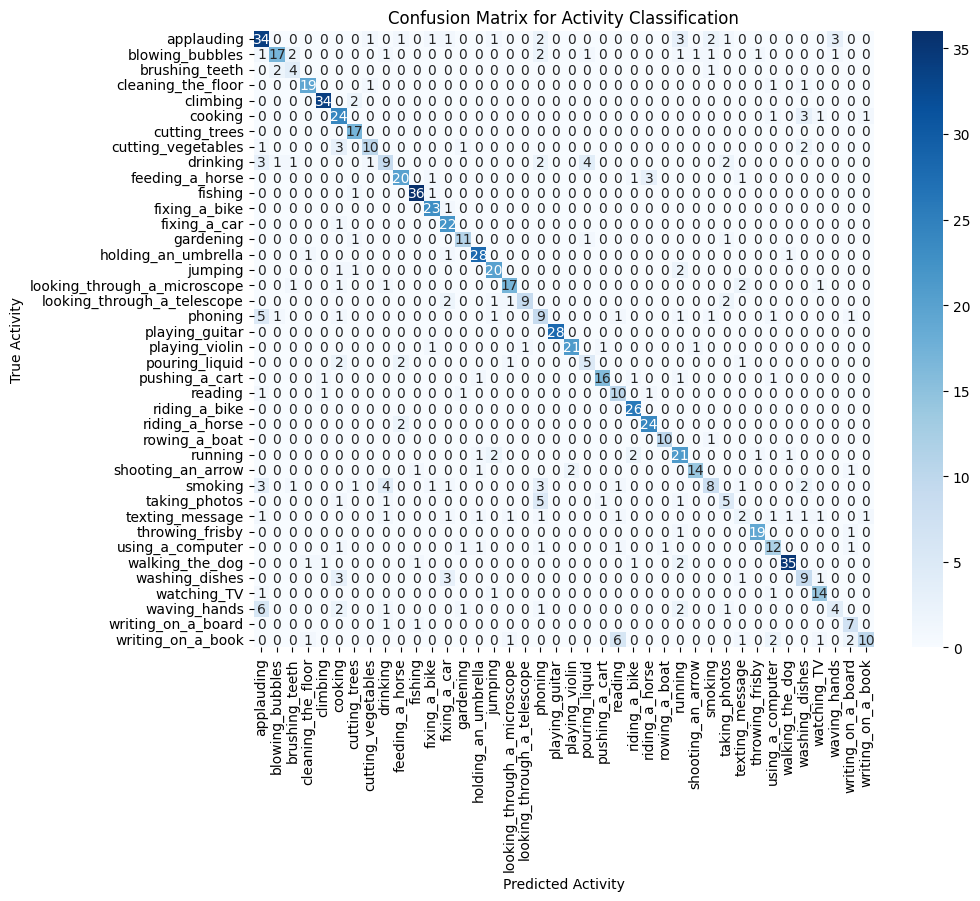

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# True labels for validation set
true_indices_activity = np.argmax(test_labels_activity, axis=1)
true_indices_person = test_labels_person

# Compute confusion matrix for activity classification
cm_activity = confusion_matrix(true_indices_activity, predicted_indices)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_activity, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(reverse_category_mapping.values()),
            yticklabels=list(reverse_category_mapping.values()))
plt.xlabel('Predicted Activity')
plt.ylabel('True Activity')
plt.title('Confusion Matrix for Activity Classification')
plt.show()


Observations:
*  The hyperparameter-tuned model performs slightly better on the holdout dataset with 74% accuracy for activity and 82.22% for person.
* This is a more reliable indication of real-world performance, it would be better to choose the hyperparameter-tuned model as the final model.
* The minor difference in validation metrics might be outweighed by the better generalization indicated by the holdout performance.
* The confusion matrix for activity classification shows high accuracy for several activities, such as "applauding," "cooking," and "playing_guitar." However, there are a few misclassifications, like between "rowing_a_boat" and "riding_a_bike," indicating potential challenges in distinguishing visually similar activities.